In [1]:
import pandas as pd
import numpy as np
import glob
import os

## Read raw data file

In [2]:
save_x_file = os.path.join("..", "data", "jikken1", "extracted_feature.csv")

_data_file = os.path.join("..", "data", "jikken1", "raw", "*.csv")
data_files = sorted(glob.glob(_data_file))

data_files

['../data/jikken1/raw/Conv-sensorA-1.csv',
 '../data/jikken1/raw/Conv-sensorB-1.csv',
 '../data/jikken1/raw/Conv-sensorC-1.csv',
 '../data/jikken1/raw/Conv-sensorD-1.csv',
 '../data/jikken1/raw/Conv-sensorE-1.csv']

In [3]:
data_list = []

for data_file in data_files:
    identifier = os.path.basename(data_file)[-7]
    
    df = pd.read_csv(data_file, encoding="shift-jis")
    
    df_nona = df.dropna(subset="label")
    print("***df_nona first", df_nona.index[0])
    
    df_filter_start_na = df.iloc[df_nona.index[0]:df_nona.index[-1], :]
    
    df_filter_start_na = df_filter_start_na.reset_index(drop=True)
    
    label = df_filter_start_na.loc[:, "label"]
    df_filter_start_na = df_filter_start_na.drop(["ts", "label"], axis=1)
    
    df_filter_start_na = df_filter_start_na.rename(lambda x: x + f"_{identifier}", axis=1)
    
    print("len(df_filter_start_na)", len(df_filter_start_na))
  
    data_list.append(df_filter_start_na)

data_df = pd.concat(data_list, axis=1)
data_df["label"] = label

data_df

***df_nona first 25422
len(df_filter_start_na) 90432
***df_nona first 24679
len(df_filter_start_na) 90432
***df_nona first 24396
len(df_filter_start_na) 90432
***df_nona first 24161
len(df_filter_start_na) 90432
***df_nona first 23883
len(df_filter_start_na) 90432


,ax_A,ay_A,az_A,gx_A,gy_A,gz_A,ax_B,ay_B,az_B,gx_B,...,gx_D,gy_D,gz_D,ax_E,ay_E,az_E,gx_E,gy_E,gz_E,label
0,-7935,1954,3465,-2788,323,-3586,-11585,-2828,1490,-6382,...,-4613,10980,-530,-8155,1505,3740,120,-1570,3440,階段降り
1,-7847,1998,3445,-2855,158,-3629,-11443,-2667,1373,-7248,...,-5308,11516,-280,-7842,1520,3598,241,-1710,3196,階段降り
2,-7647,2051,3387,-3008,-48,-3592,-11199,-2462,1299,-8083,...,-5363,11230,-129,-7432,1407,3462,223,-1685,2915,階段降り
3,-7495,2100,3309,-3124,-310,-3531,-10965,-2296,1021,-8907,...,-6266,10797,194,-7208,1354,3354,34,-1649,2635,階段降り
4,-7315,1954,3245,-3191,-548,-3421,-10652,-2233,782,-9650,...,-7906,11059,322,-7017,1158,3261,-264,-1673,2366,階段降り
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90427,-6387,6016,4700,199,-353,-147,-5169,-6183,5640,-16,...,69,-92,-189,-8550,1476,4765,205,76,-66,座っている
90428,-6358,6031,4749,278,-487,-196,-5145,-6197,5645,20,...,44,-99,-183,-8536,1476,4800,217,45,-108,座っている
90429,-6280,5997,4847,351,-554,-202,-5174,-6188,5577,130,...,-4,-129,-183,-8497,1529,4721,205,45,-120,座っている
90430,-6265,6011,4837,400,-652,-214,-5193,-6144,5543,160,...,-29,-123,-219,-8511,1515,4707,205,15,-169,座っている


In [4]:
data_df["label"].value_counts()

歩いている    12856
立っている    12566
階段上り     12278
走っている    12233
階段降り     12222
座っている    12065
Name: label, dtype: int64

In [5]:
label_list = list(data_df["label"].value_counts().keys())
label_list

['歩いている', '立っている', '階段上り', '走っている', '階段降り', '座っている']

## extract feature

In [7]:
%%writefile preprocessing.py

from scipy.fftpack import fft
from scipy import signal
import numpy as np
import pandas as pd


def Calc_Time(signalData):
    Mean = np.mean(signalData) # 平均値
    Std = np.std(signalData - Mean)  #標準偏差

    return [Mean, Std]

# RMSを求める関数
def Calc_RMS(signalData):
    a = signalData * signalData  # 二乗
    sum_a = np.sum(a)  # 総和
    sqrt_a = np.sqrt(sum_a) # 平方根
    RMS = np.mean(sqrt_a) # 平均値
    
    return RMS

def Calc_Freq(signalData):
    L = len(signalData) # 信号長
    Win = signal.hann(L) #ハニング窓を使用

    S = np.fft.fft(Win * signalData) # 振幅スペクトル
    PowerSpectrum = (S * S.conjugate()) # パワースペクトル
    Energy = np.sum(PowerSpectrum.real)

    P = PowerSpectrum.real/np.sum(Energy)
    Entropy = -np.sum(P*np.log(P))


    return [Energy, Entropy]


Writing preprocessing.py


In [8]:
import preprocessing

In [10]:
data_df.head()

,ax_A,ay_A,az_A,gx_A,gy_A,gz_A,ax_B,ay_B,az_B,gx_B,...,gx_D,gy_D,gz_D,ax_E,ay_E,az_E,gx_E,gy_E,gz_E,label
0,-7935,1954,3465,-2788,323,-3586,-11585,-2828,1490,-6382,...,-4613,10980,-530,-8155,1505,3740,120,-1570,3440,階段降り
1,-7847,1998,3445,-2855,158,-3629,-11443,-2667,1373,-7248,...,-5308,11516,-280,-7842,1520,3598,241,-1710,3196,階段降り
2,-7647,2051,3387,-3008,-48,-3592,-11199,-2462,1299,-8083,...,-5363,11230,-129,-7432,1407,3462,223,-1685,2915,階段降り
3,-7495,2100,3309,-3124,-310,-3531,-10965,-2296,1021,-8907,...,-6266,10797,194,-7208,1354,3354,34,-1649,2635,階段降り
4,-7315,1954,3245,-3191,-548,-3421,-10652,-2233,782,-9650,...,-7906,11059,322,-7017,1158,3261,-264,-1673,2366,階段降り


In [11]:
# data: 100Hz 
Window_size = 200 # 2s
over_lap = 0.5

overlap_data = Window_size * over_lap

margin = 300
index = 0
loop = 0

feature_list = []


while index < data_df.shape[0]:
    if pd.isna(data_df['label'][index]):
        index = index + 1
        continue

    count = 0
    while count < margin:
        count, index = count + 1, index + 1
        
        
    if index  >= data_df.shape[0]: break
    current_label = data_df.loc[index, 'label']
    
    while not pd.isna(data_df['label'][index + Window_size]) and data_df['label'][index + Window_size] == current_label:
        signal_data = data_df.iloc[index: index + Window_size, :]
        index = index + Window_size

        for sensor_name in "ABCDE":
            for axis in "xyz":
                exec(f"data_df.loc[index, 'a{axis}_{sensor_name}_mean'], data_df.loc[index, 'a{axis}_{sensor_name}_std'] = preprocessing.Calc_Time(signal_data.loc[:, 'a{axis}_{sensor_name}'])")
                exec(f"data_df.loc[index, 'a{axis}_{sensor_name}_RMS'] = preprocessing.Calc_RMS(signal_data.loc[:, 'a{axis}_{sensor_name}'])")
                exec(f"data_df.loc[index, 'a{axis}_{sensor_name}_energy'], data_df.loc[index, 'a{axis}_{sensor_name}_entropy'] = preprocessing.Calc_Freq(signal_data.loc[:, 'a{axis}_{sensor_name}'])")
                
        index = index - int(overlap_data)
        if index + Window_size >= data_df.shape[0]: break
        
data_df

,ax_A,ay_A,az_A,gx_A,gy_A,gz_A,ax_B,ay_B,az_B,gx_B,...,ay_E_mean,ay_E_std,ay_E_RMS,ay_E_energy,ay_E_entropy,az_E_mean,az_E_std,az_E_RMS,az_E_energy,az_E_entropy
0,-7935,1954,3465,-2788,323,-3586,-11585,-2828,1490,-6382,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-7847,1998,3445,-2855,158,-3629,-11443,-2667,1373,-7248,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-7647,2051,3387,-3008,-48,-3592,-11199,-2462,1299,-8083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-7495,2100,3309,-3124,-310,-3531,-10965,-2296,1021,-8907,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-7315,1954,3245,-3191,-548,-3421,-10652,-2233,782,-9650,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90427,-6387,6016,4700,199,-353,-147,-5169,-6183,5640,-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90428,-6358,6031,4749,278,-487,-196,-5145,-6197,5645,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90429,-6280,5997,4847,351,-554,-202,-5174,-6188,5577,130,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90430,-6265,6011,4837,400,-652,-214,-5193,-6144,5543,160,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
feature_df = data_df[~ pd.isna(data_df["ay_D_mean"])]
feature_df

,ax_A,ay_A,az_A,gx_A,gy_A,gz_A,ax_B,ay_B,az_B,gx_B,...,ay_E_mean,ay_E_std,ay_E_RMS,ay_E_energy,ay_E_entropy,az_E_mean,az_E_std,az_E_RMS,az_E_energy,az_E_entropy
500,-7232,2388,1644,-12429,2244,8895,-7239,-1613,640,-6480,...,1806.145,1795.656586,36018.168568,1.110045e+11,3.056860,3081.645,1990.262201,51880.014524,2.080846e+11,2.106770
600,-13570,2652,760,31290,-3085,-11007,-6204,-1442,1036,6160,...,1706.790,2538.833273,43263.856717,1.574565e+11,3.429951,3067.520,2349.352196,54642.720814,2.184749e+11,2.321673
700,-8145,665,2195,-24069,7036,3468,-9847,-10382,-102,-13809,...,1464.050,2965.510483,46771.133897,1.341559e+11,3.441022,3302.915,2665.429948,60022.936124,2.246754e+11,2.352513
800,-13623,3101,-675,2345,847,12614,-11077,-1686,2437,403,...,1347.885,2932.129249,45638.089147,1.335287e+11,3.443275,4089.310,2516.219039,67902.598669,3.718134e+11,2.009156
900,-8184,2271,3323,1760,-4408,3809,-5428,-2145,713,2910,...,1099.540,2305.086983,36117.625088,1.074096e+11,3.794312,3786.320,2300.079507,62652.350124,2.883912e+11,1.982301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89956,-6275,6041,4940,83,-30,-135,-5418,-6158,5425,26,...,1497.210,31.004450,21178.286333,3.328892e+10,0.876605,5204.645,51.739047,73608.432268,4.046149e+11,0.872792
90056,-6372,5958,4954,113,-66,-86,-5413,-6163,5294,124,...,1499.950,34.189289,21218.006080,3.370895e+10,0.878674,5157.960,49.400085,72947.915296,3.952942e+11,0.872417
90156,-6319,5923,4988,144,-18,-92,-5364,-6256,5328,57,...,1516.295,29.969451,21447.837630,3.428604e+10,0.876223,5124.670,43.537468,72476.393564,3.937910e+11,0.874623
90256,-6358,6055,5008,-57,311,-14,-5369,-6222,5425,51,...,1525.745,37.712597,21583.883084,3.473797e+10,0.875050,5089.265,45.620662,71975.967496,3.861778e+11,0.873098


In [13]:
for sensor_name in "ABCDE":
    for axis in "xyz":
        feature_df = feature_df.drop([f"a{axis}_{sensor_name}"], axis=1)
        feature_df = feature_df.drop([f"g{axis}_{sensor_name}"], axis=1)

In [14]:
feature_df = feature_df.reset_index(drop=True)
feature_df.head()

,label,ax_A_mean,ax_A_std,ax_A_RMS,ax_A_energy,ax_A_entropy,ay_A_mean,ay_A_std,ay_A_RMS,ay_A_energy,...,ay_E_mean,ay_E_std,ay_E_RMS,ay_E_energy,ay_E_entropy,az_E_mean,az_E_std,az_E_RMS,az_E_energy,az_E_entropy
0,階段降り,-10095.115,3193.308573,149738.816948,1.589442e+12,1.291517,2333.925,2153.205443,44907.682160,1.143133e+11,...,1806.145,1795.656586,36018.168568,1.110045e+11,3.056860,3081.645,1990.262201,51880.014524,2.080846e+11,2.106770
1,階段降り,-9774.820,3475.480257,146714.736172,1.608769e+12,1.477448,1566.395,2285.059553,39179.306923,1.376261e+11,...,1706.790,2538.833273,43263.856717,1.574565e+11,3.429951,3067.520,2349.352196,54642.720814,2.184749e+11,2.321673
2,階段降り,-9877.695,4102.551451,151261.222344,1.672245e+12,1.481259,2008.595,2648.684368,47010.600411,2.397319e+11,...,1464.050,2965.510483,46771.133897,1.341559e+11,3.441022,3302.915,2665.429948,60022.936124,2.246754e+11,2.352513
3,階段降り,-10688.945,3710.319677,160012.510333,1.844237e+12,1.441390,2422.165,2083.888893,45187.334962,9.098953e+10,...,1347.885,2932.129249,45638.089147,1.335287e+11,3.443275,4089.310,2516.219039,67902.598669,3.718134e+11,2.009156
4,階段降り,-10026.590,3608.493259,150700.849785,1.678992e+12,1.291513,2121.900,1853.437123,39843.917428,7.196488e+10,...,1099.540,2305.086983,36117.625088,1.074096e+11,3.794312,3786.320,2300.079507,62652.350124,2.883912e+11,1.982301


In [15]:
len(feature_df)

687

In [16]:
feature_df.to_csv(save_x_file, index=False)

## Create Base model

In [1]:
import pandas as pd
import numpy as np

df_feature = pd.read_csv('../data/jikken1/extracted_feature.csv') #読み込み

In [2]:
df_feature.head(5)

,label,ax_A_mean,ax_A_std,ax_A_RMS,ax_A_energy,ax_A_entropy,ay_A_mean,ay_A_std,ay_A_RMS,ay_A_energy,...,ay_E_mean,ay_E_std,ay_E_RMS,ay_E_energy,ay_E_entropy,az_E_mean,az_E_std,az_E_RMS,az_E_energy,az_E_entropy
0,階段降り,-10095.115,3193.308573,149738.816948,1.589442e+12,1.291517,2333.925,2153.205443,44907.682160,1.143133e+11,...,1806.145,1795.656586,36018.168568,1.110045e+11,3.056860,3081.645,1990.262201,51880.014524,2.080846e+11,2.106770
1,階段降り,-9774.820,3475.480257,146714.736172,1.608769e+12,1.477448,1566.395,2285.059553,39179.306923,1.376261e+11,...,1706.790,2538.833273,43263.856717,1.574565e+11,3.429951,3067.520,2349.352196,54642.720814,2.184749e+11,2.321673
2,階段降り,-9877.695,4102.551451,151261.222344,1.672245e+12,1.481259,2008.595,2648.684368,47010.600411,2.397319e+11,...,1464.050,2965.510483,46771.133897,1.341559e+11,3.441022,3302.915,2665.429948,60022.936124,2.246754e+11,2.352513
3,階段降り,-10688.945,3710.319677,160012.510333,1.844237e+12,1.441390,2422.165,2083.888893,45187.334962,9.098953e+10,...,1347.885,2932.129249,45638.089147,1.335287e+11,3.443275,4089.310,2516.219039,67902.598669,3.718134e+11,2.009156
4,階段降り,-10026.590,3608.493259,150700.849785,1.678992e+12,1.291513,2121.900,1853.437123,39843.917428,7.196488e+10,...,1099.540,2305.086983,36117.625088,1.074096e+11,3.794312,3786.320,2300.079507,62652.350124,2.883912e+11,1.982301


In [3]:
print(df_feature["label"].value_counts())

歩いている    119
立っている    117
走っている    114
階段降り     113
階段上り     113
座っている    111
Name: label, dtype: int64


In [4]:
label_list = list(df_feature["label"].value_counts().keys())
print(label_list)
eng_label_dict = dict(zip(
    ['歩いている', '立っている', '走っている', '階段降り', '階段上り', '座っている'],
    ['Walking', 'Standing', 'Jogging', 'DownStair', 'Upstair', 'Sit']
))

eng_label_list = [eng_label_dict[i] for i in label_list]
print(eng_label_list)

['歩いている', '立っている', '走っている', '階段降り', '階段上り', '座っている']
['Walking', 'Standing', 'Jogging', 'DownStair', 'Upstair', 'Sit']


In [5]:
#ラベル名ごとにカウント
data_all = []
for activity_label in label_list:
    
    one_activity_data = df_feature[df_feature['label'] == activity_label]
    data_all.append(one_activity_data)
    

label_all = [activity_data.pop("label") for activity_data in data_all]

In [6]:
from sklearn.model_selection import KFold


def k_fold_eval(model):
    n_split = 10

    #KFoldの設定(5個に分割)
    kf = KFold(n_splits = n_split, shuffle = True, random_state = 42)

    k_index_list = []

    for activity_data in data_all:
        k_index_list.append(list(kf.split(activity_data)))
        
    all_test = []
    all_pred = []

    for k in range(n_split):

        train_x, train_y, test_x, test_y = [[] for _ in range(4)]
        
        for i, activity_data in enumerate(data_all):

            activity_x_train, activity_x_test = activity_data.values[ k_index_list[i][k][0] ], activity_data.values[ k_index_list[i][k][1] ]
            activity_y_train, activity_y_test = label_all[i].values[ k_index_list[i][k][0] ], label_all[i].values[ k_index_list[i][k][1] ]

            train_x.append(activity_x_train)
            test_x.append(activity_x_test)

            train_y.append(activity_y_train)
            test_y.append(activity_y_test)

        train_x = np.concatenate(train_x, axis=0)
        train_y = np.concatenate(train_y, axis=0)
        
        test_x = np.concatenate(test_x, axis=0)
        test_y = np.concatenate(test_y, axis=0)
        
        model.fit(train_x, train_y)
        
        y_pred = model.predict(test_x)
        
        all_test.extend(test_y)
        all_pred.extend(y_pred)
        
    return all_test, all_pred

### test with DecisionTreeClassifier

<AxesSubplot:>

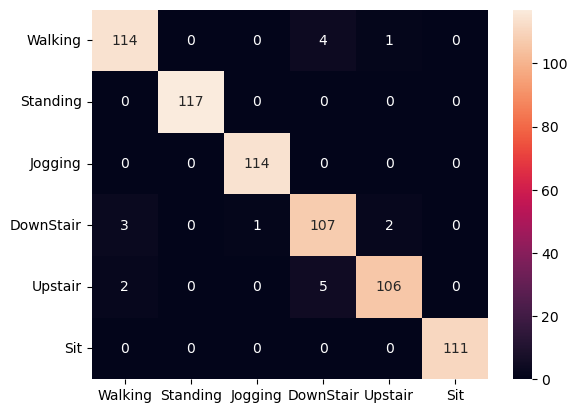

In [7]:
from sklearn import tree
from sklearn.metrics import confusion_matrix
import seaborn as sns

Model = tree.DecisionTreeClassifier(criterion='gini', min_samples_leaf=1 , max_depth=6) # モデル構造の定義

all_test, all_pred = k_fold_eval(Model)
cf = confusion_matrix(all_test, all_pred, labels=label_list)
sns.heatmap(cf, annot=True, xticklabels=eng_label_list, yticklabels=eng_label_list, fmt='g')

In [8]:
from sklearn.metrics import precision_recall_fscore_support

print("precision_recall_fscore_support: ")
print()
print(*eng_label_list, sep=" "*4)
print(*precision_recall_fscore_support(all_test, all_pred, labels=label_list), sep="\n")

precision_recall_fscore_support: 

Walking    Standing    Jogging    DownStair    Upstair    Sit
[0.95798319 1.         0.99130435 0.92241379 0.97247706 1.        ]
[0.95798319 1.         1.         0.94690265 0.9380531  1.        ]
[0.95798319 1.         0.99563319 0.93449782 0.95495495 1.        ]
[119 117 114 113 113 111]


### test with SVM

<AxesSubplot:>

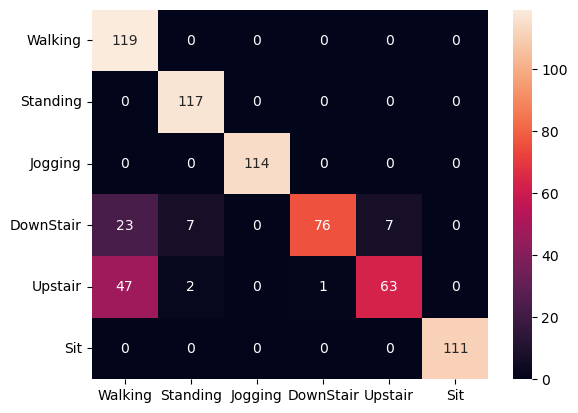

In [12]:
from sklearn import svm
from sklearn.metrics import confusion_matrix
import seaborn as sns

Model = svm.SVC(kernel='rbf', degree=4) # モデル構造の定義

all_test, all_pred = k_fold_eval(Model)
cf = confusion_matrix(all_test, all_pred, labels=label_list)
sns.heatmap(cf, annot=True, xticklabels=eng_label_list, yticklabels=eng_label_list, fmt='g')

In [13]:
from sklearn.metrics import precision_recall_fscore_support

print("precision_recall_fscore_support: ")
print()
print(*eng_label_list, sep=" "*4)
print(*precision_recall_fscore_support(all_test, all_pred, labels=label_list), sep="\n")

precision_recall_fscore_support: 

Walking    Standing    Jogging    DownStair    Upstair    Sit
[0.62962963 0.92857143 1.         0.98701299 0.9        1.        ]
[1.         1.         1.         0.67256637 0.55752212 1.        ]
[0.77272727 0.96296296 1.         0.8        0.68852459 1.        ]
[119 117 114 113 113 111]
